In [71]:
# Importing Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import sklearn.metrics as metrics
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

### Loading Data

In [72]:
# Loading Data
fraud_df = pd.read_csv("/content/drive/MyDrive/Fraud Detection/Fraud.csv")

### Pre-processing

In [73]:
# Printing Head rows of the Data
print(fraud_df.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [74]:
# Printing basic information of the dataframe
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [75]:
# Columns of the Dataset
print("Columns of the Dataset:-",fraud_df.columns)

Columns of the Dataset:- Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [76]:
# Calculating Nan values in each column
for column in fraud_df.columns:
  print(column,fraud_df[column].isna().sum())

step 0
type 0
amount 0
nameOrig 0
oldbalanceOrg 0
newbalanceOrig 0
nameDest 0
oldbalanceDest 0
newbalanceDest 0
isFraud 0
isFlaggedFraud 0


As we can see that there are 0 NaN values in the dataset.

In [77]:
# Checking the distribution b/w fair and fraud transactions
fair_transac = len(fraud_df[fraud_df['isFraud']==0])
fraud_transac = len(fraud_df[fraud_df['isFraud']==1])
total_transac = len(fraud_df)
print("Fair Transactions:-",fair_transac)
print("Fraud Transactions:-",fraud_transac)
print("Percentage of Fair Transactions:-",(fair_transac/total_transac)*100)
print("Percentage of Fraud Transactions:-",(fraud_transac/total_transac)*100)

Fair Transactions:- 6354407
Fraud Transactions:- 8213
Percentage of Fair Transactions:- 99.87091795518198
Percentage of Fraud Transactions:- 0.12908204481801522


As we can see that the data is skewed. There is imbalance in the data for the classes. Therefore we need to choose the model algorithm and metrics appropriately,

####Checking Transactions for customers that start with 'M'(Merchants)

In [78]:
merchants_transac = fraud_df[fraud_df['nameDest'].str.contains('M')]
merchants_transac.head()

# Similarly for nameOrig column


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


We can see that the transactions having nameDest or nameOrig start with 'M' do not contain information regarding oldbalanceDest and newbalanceDest

### Visualizing Data with Graphs

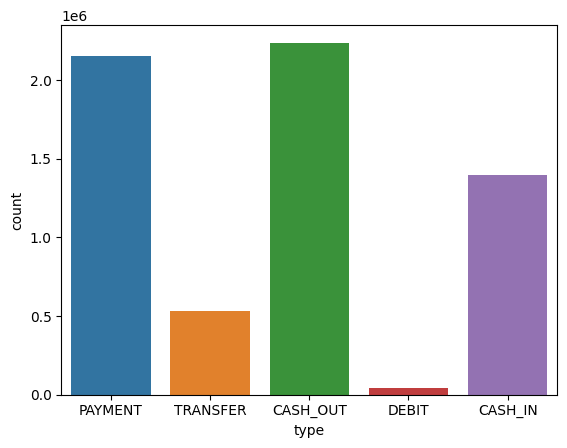

In [79]:
# Count of number of transactions for each Type
ax = sns.countplot(data = fraud_df,x = "type")
plt.show()

We can see that most of the transactions are of CASH_OUT, PAYMENT and CASH_IN type and very few are of TRANSFER AND DEBIT types.

<ipython-input-80-e12b70ee6454>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(fraud_df.corr(), annot=True)


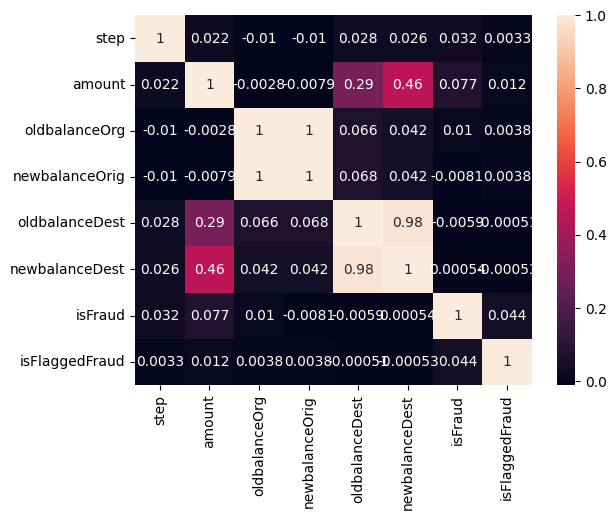

In [80]:
# Plotting Heatmap of the correlation matrix
ax = sns.heatmap(fraud_df.corr(), annot=True)

As we can see from the Heatmap, there is high correlation b/w these columns:-\
(i) **newbalanceOrig and oldbalanceOrig**\
(ii) **newbalanceDest and oldbalanceDest**

Therefore while training the model we will take only one of these columns

#### Label Encoding the columns having Object as data type

During Training, we need the data type of the column as numeric in order to train. Therefore using LabelEncoder, we are converting Object data type to numeric

In [81]:
# Label encoding the columns with Object as data type with numeric values
le  = LabelEncoder()

for column in ['type','nameOrig','nameDest']:
  fraud_df['encoded_'+column] = le.fit_transform(fraud_df[column].astype(str))

print(fraud_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 14 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   type              object 
 2   amount            float64
 3   nameOrig          object 
 4   oldbalanceOrg     float64
 5   newbalanceOrig    float64
 6   nameDest          object 
 7   oldbalanceDest    float64
 8   newbalanceDest    float64
 9   isFraud           int64  
 10  isFlaggedFraud    int64  
 11  encoded_type      int64  
 12  encoded_nameOrig  int64  
 13  encoded_nameDest  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 679.6+ MB
None


####Checking for Multicollinearity using VIF

From the above Correlation matrix, we saw that oldbalanceOrg and newbalanceOrig have too high correlation thus they are highly correlated. Similarly oldbalanceDest and newbalanceDest. Also nameDest is connected to nameOrig.

Thus it is better to combine these pairs of collinear attributes and calculate their correlation and use them for training.

In [82]:
# Creating new columns to avoid Collinearity
fraud_df['Actual_amount_orig'] = fraud_df.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
fraud_df['Actual_amount_dest'] = fraud_df.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
fraud_df['TransactionPath'] = fraud_df.apply(lambda x: x['encoded_nameOrig'] + x['encoded_nameDest'],axis=1)

In [83]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   step                int64  
 1   type                object 
 2   amount              float64
 3   nameOrig            object 
 4   oldbalanceOrg       float64
 5   newbalanceOrig      float64
 6   nameDest            object 
 7   oldbalanceDest      float64
 8   newbalanceDest      float64
 9   isFraud             int64  
 10  isFlaggedFraud      int64  
 11  encoded_type        int64  
 12  encoded_nameOrig    int64  
 13  encoded_nameDest    int64  
 14  Actual_amount_orig  float64
 15  Actual_amount_dest  float64
 16  TransactionPath     int64  
dtypes: float64(7), int64(7), object(3)
memory usage: 825.2+ MB


In [84]:
# Calculating VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):

    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return(vif)

calc_vif(fraud_df[['encoded_type','amount','isFraud','isFlaggedFraud','Actual_amount_orig','Actual_amount_dest','TransactionPath']])


,variables,VIF
0,encoded_type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


We can notice that these variables have VIF < 5, which is good. We have only taken these variables as these will be used for training.

### Data Preparation

In [85]:
# Perform Scaling on Amount as it helps in better convergence during training
scaler = StandardScaler()
fraud_df["NormalizedAmount"] = scaler.fit_transform(fraud_df["amount"].values.reshape(-1, 1))
# fraud_df.drop(["amount"], inplace= True, axis= 1)

X = fraud_df[['encoded_type','amount','isFraud','isFlaggedFraud','Actual_amount_orig','Actual_amount_dest','TransactionPath']]
Y = fraud_df[['isFraud']]

####Splitting Data into Training and Testing

In [86]:
# Split the data (80-20 split)
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.2, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (5090096, 7)
Shape of X_test:  (1272524, 7)


### Model

As we know that we have imbalance data, therefore the algorithms that perform better in that case are Tree-based algorithms or Boosting algorithms like XGBoost

In [87]:
# DECISION TREE

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test) * 100

In [88]:
# RANDOM FOREST

random_forest = RandomForestClassifier(n_estimators= 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test) * 100

<ipython-input-88-98b802f3ce30>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train, Y_train)


In [89]:
# XGBoost Regressor
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X_train, Y_train)

Y_pred_xgb = xgb_model.predict(X_test)

xgboost_score = random_forest.score(X_test, Y_test) * 100

[17:01:37] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [90]:
# Print scores of our classifiers

print("Decision Tree Score: ", decision_tree_score)
print("Random Forest Score: ", random_forest_score)
print("XGBoost Regressor Score: ", xgboost_score)

Decision Tree Score:  100.0
Random Forest Score:  100.0
XGBoost Regressor Score:  100.0


### Metrics Calculation

As it is an imbalance dataset, the best metrics to check the performance of model are:-\
(i) Precision\
(ii) Recall\
(iii) F-1 Score\
(iv) Confusion Matrix

In [91]:
# Classification Report for Decision Tree
classification_report_dt = classification_report(Y_test, Y_pred_dt.round())
print("Classification Report - Decision Tree")
print(classification_report_dt)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       1.00      1.00      1.00      1620

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



In [92]:
# Classification Report for Random Forest
classification_report_rf = classification_report(Y_test, Y_pred_rf.round())
print("Classification Report - Random Forest")
print(classification_report_rf)

Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       1.00      1.00      1.00      1620

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



In [93]:
# Classification Report for XGBoost
classification_report_xgb = classification_report(Y_test, Y_pred_xgb.round())
print("Classification Report - XGBoost")
print(classification_report_xgb)

Classification Report - XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       1.00      1.00      1.00      1620

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524



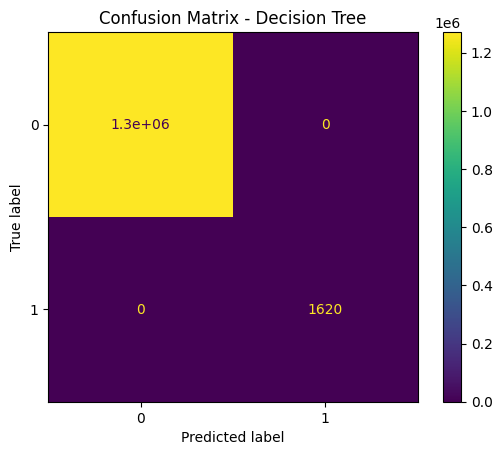

In [94]:
# Confusion Matrix for Decision Tree
cm_dt = confusion_matrix(Y_test,Y_pred_dt.round())
disp = ConfusionMatrixDisplay(cm_dt)

disp.plot()
plt.title('Confusion Matrix - Decision Tree')
plt.show()

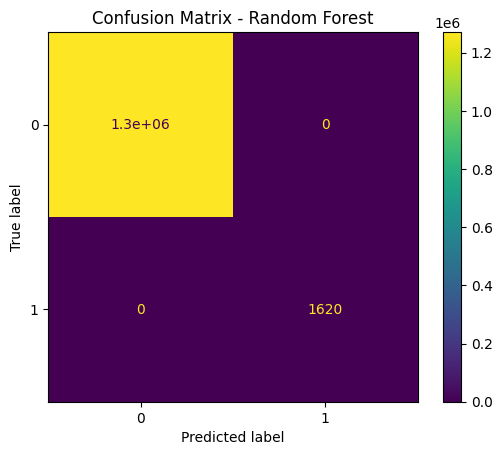

In [95]:
# Confusuion Matrix for Random Forest
cm_rf = confusion_matrix(Y_test,Y_pred_rf.round())
disp = ConfusionMatrixDisplay(cm_rf)

disp.plot()
plt.title('Confusion Matrix - Random Forest')
plt.show()

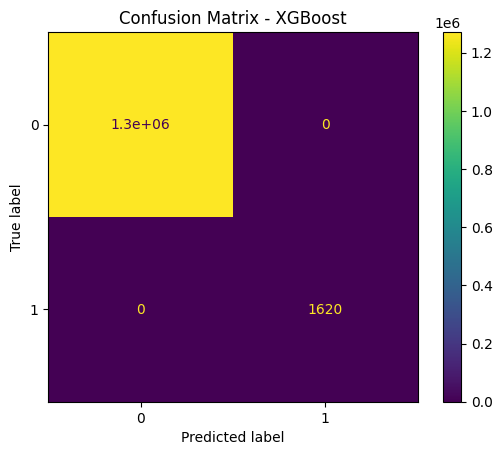

In [96]:
# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(Y_test,Y_pred_xgb.round())
disp = ConfusionMatrixDisplay(cm_xgb)

disp.plot()
plt.title('Confusion Matrix - XGBoost')
plt.show()

###Conclusion

As we can see after training three models:- Decision Tree, Random Forest, XGBoost and from the result that we are getting precision and recall, both as 1 in all three. Therefore all the data is being labelled correctly on the test set.\
This is ***the reason we didn't use fine-tuning*** here as we are already getting good results.


####Assignment Questions

**Q1. How did you select variables to be included in the model?**\
Ans - Firstly I checked the correlation b/w the variables through which it is seen that the variables newbalanceOrig and oldbalanceOrig, newbalanceDest and oldbalanceDest are highly correlated. Therefore I created custom variables Actual_amount_orig and Actual_amount_dest which represent the information carried by newbalanceOrig and newbalanceDest but without any correlation. I also created a variable TransactionPath which is just the combination of nameOrig and nameDest.\

**Q2. What are the key factors that predict fraudulent customer?**\
Ans - Some of these factors are:- \
(i) Amount of Transaction\
(ii) Customer Transaction History\
(iii) Sender and Receiver transaction relation

**Q3. Do these factors make sense?**\
Ans - Yes, some of these factors make sense. For exp -  it is likely that in case of fraud large amount of money would be involved. Also it is likely that if a person has commited fraud before, he/she might do it again.
On the other hand, some variable like Transaction Type might not matter that much as it is difficult to know if a payment do through cash or transfer is a fraud or not.

**Q4. What kind of prevention should be adopted while company update its infrastructure?**\
Ans - Fraud Monitoring system should be installed and real-time transactions should be passes through them.\
Aside from this, a virtual identity can be made for each customer where the identity will be tied through the customer history and his/her resource history. This can help in detecting which person is more likely to commit fraud.

**Q5. Assuming these actions have been implemented, how would you determine if they work?**\
Ans - The best way to be satisfied that the software is working correctly, you should try to commit fraud yourself. This will help you understand how the software works and whether it is able to detect all types of fraud.


###Thank You! Hope you find the assignment results satisfactory !